<img src='https://www.actris.eu/sites/default/files/inline-images/Actris%20logo.png' width=200 align=right>

# ACTRIS DC 
### Daily, monthly and annual mean concentrations of NO2

Example script to plot the timeseries of daily and monthly mean of NO2 mass concentration data for 2022 at ACTRIS stations. Furher, the annual means are plotted on a European map. 

### Import libraries

In [6]:
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import json
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.colors import BoundaryNorm
from matplotlib import colormaps as cm

### Load data

In this example the data is selected by searching in the [ACTRIS Data Portal](https://data.actris.eu). A basket (.json) file from choosing variable **Nitrogen dioxide mass concentration** and framework **ACTRIS** is stored in *static*. A more thorugh example of this process is shown in file "Search and access/Search with the ACTRIS Data Portal.ipynb".

In [7]:
#named the basket file downloaded from ACTRIS Data Portal "basket_no2_2022.json"
with open('static/basket_no2_2022.json') as f:
  basket = json.load(f)

# get the list of the urls in the NO2 files in netCDF format
df = pd.DataFrame(basket).T
file_urls = df['opendapUrl'].tolist()
print(file_urls)

['https://thredds.nilu.no/thredds/dodsC/ebas_doi/JE/CK/XJ/JECK-XJ9C.nc', 'https://thredds.nilu.no/thredds/dodsC/ebas_doi/XC/VP/A5/XCVP-A5BH.nc', 'https://thredds.nilu.no/thredds/dodsC/ebas_doi/3M/9Z/64/3M9Z-648F.nc', 'https://thredds.nilu.no/thredds/dodsC/ebas_doi/9K/6S/D6/9K6S-D6A9.nc', 'https://thredds.nilu.no/thredds/dodsC/ebas_doi/DQ/83/EQ/DQ83-EQBE.nc']


### Define the year and variable of interest

In [8]:
# define the variable of interest and the year of interest
variable_interested_standard_name = 'mass_concentration_of_nitrogen_dioxide_expressed_as_nitrogen_in_air'
year_interested = 2022

### Calculate daily, monthly and annual mean concentrations
Inspect the data coverage by printing out how many days of data are available

In [11]:
# define dataframes with the data of interest
daily_means_all_sites = []
monthly_means_all_sites = []
annual_means_all_sites = []
site_name_list = []

for i in range(len(file_urls)):
    # Open the netCDF file
    data = xr.open_dataset(file_urls[i])
    print(i)

    # Check if the dataset's time range overlaps with the wanted period
    dataset_start_time = data.time.min().values
    dataset_end_time = data.time.max().values


    # check time period of the data
    if (data.time.dt.year == year_interested).any():

        # check if the dataset contains the variable of interest
        for var in data.data_vars:
            if 'standard_name' in data[var].attrs and data[var].attrs['standard_name'] == variable_interested_standard_name:
                print(' File %d, %s, variable: %s %s Period: %s - %s' % (i, data.attrs['ebas_station_code'], "{:<35s}".format(var), "{:<40s}".format('('+data.attrs['ebas_station_name']+')'), data.time.min().values, data.time.max().values))

                # get the variable values for the year of interest
                variable_values = data[var].sel(time = data.time.dt.year == year_interested)

                # Calculate daily, monthly and annual means
                daily_means = variable_values.resample(time='1D').mean('time')
                print('      ..has data for '+str(len(daily_means))+' days..')
                monthly_means = variable_values.resample(time='M').mean('time')
                annual_means = variable_values.resample(time='Y').mean('time')
                #add the means to the file that collects all the sites
                daily_means_all_sites.append(daily_means)
                monthly_means_all_sites.append(monthly_means)
                annual_means_all_sites.append(annual_means)
                site_name_list.append(data.attrs['ebas_station_name'])
                break              

        else:
            print(f"File {i} does not contain data in the desired time range.")
    data.close() 

0
 File 0, FI0050R, variable: nitrogen_dioxide_ug_N_per_m3_amean  (Hyytiälä)                               Period: 2018-01-01T00:30:00.000000000 - 2022-12-31T23:30:00.000000000
      ..has data for 365 days..
1
 File 1, IT0009R, variable: nitrogen_dioxide_ug_N_per_m3_amean  (Monte Cimone)                           Period: 2021-01-01T00:30:00.000000000 - 2022-12-31T23:30:00.000000000
      ..has data for 365 days..
2
 File 2, CZ0003R, variable: nitrogen_dioxide_ug_N_per_m3        (Kosetice (NAOK))                        Period: 2022-01-01T00:30:00.000000000 - 2022-12-31T23:30:00.000000000
      ..has data for 365 days..
3
 File 3, FR0020R, variable: nitrogen_dioxide_ug_N_per_m3        (SIRTA Atmospheric Research Observatory) Period: 2022-01-01T00:30:00.000000000 - 2022-12-31T23:30:00.000000000
      ..has data for 365 days..
4
 File 4, CH0001G, variable: nitrogen_dioxide_ug_N_per_m3        (Jungfraujoch)                           Period: 2021-01-01T00:30:00.000000000 - 2022-12-31T23:30:

#### Plot daily and monthly with one panel for each site

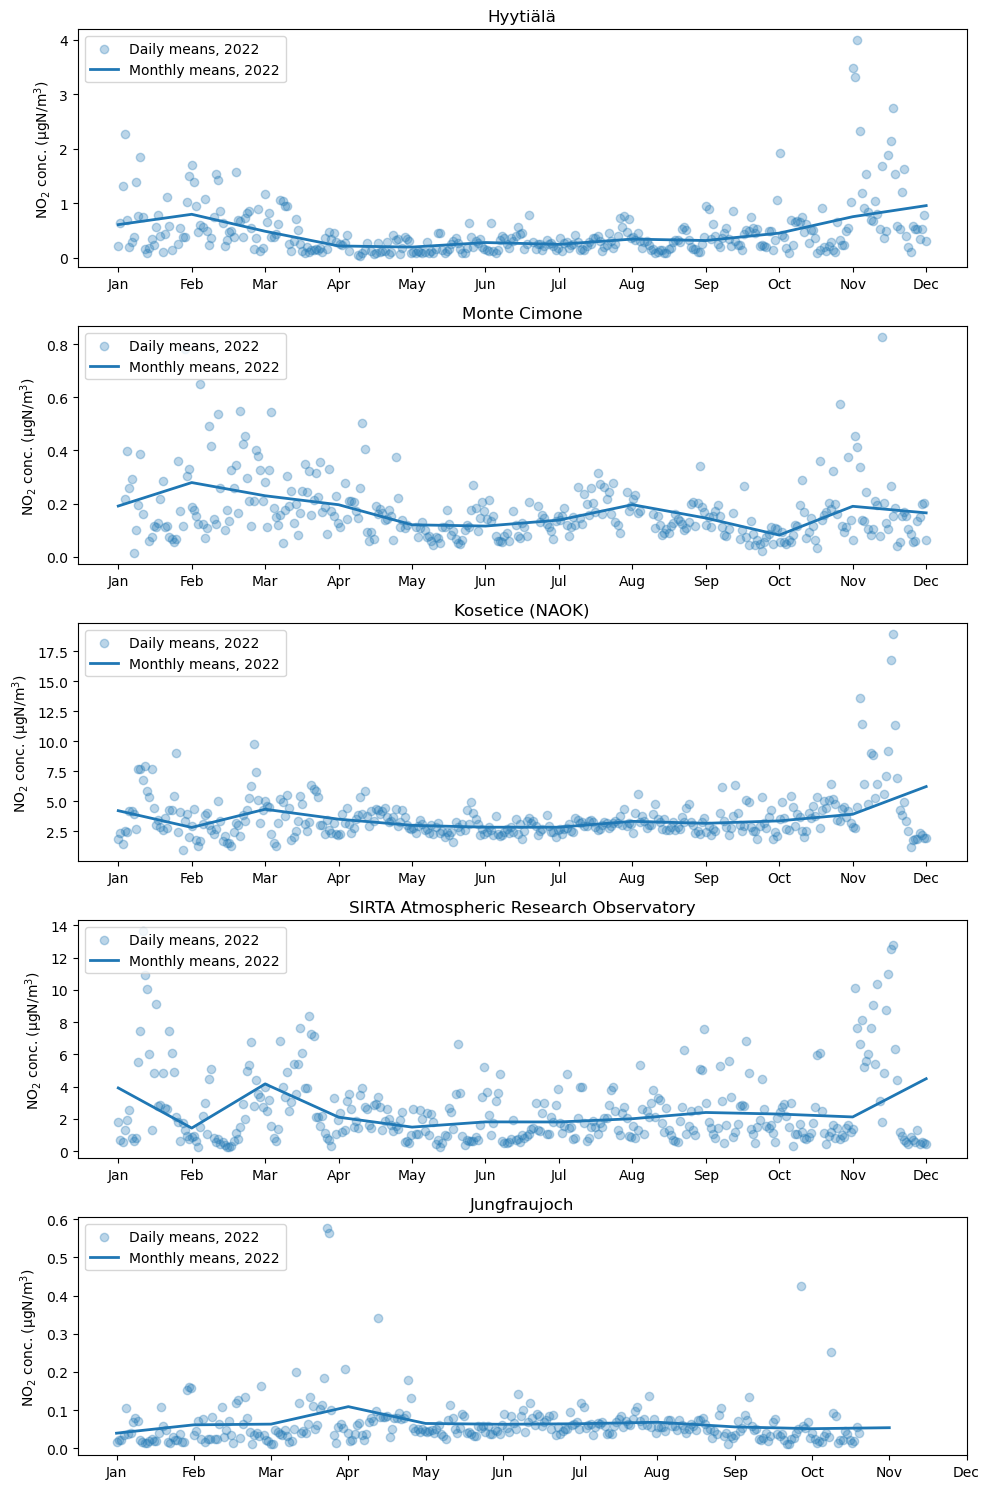

In [12]:
#First, prepare some variables to use as x values in the plotting
ndays=len(daily_means.time)
nmonths=len(monthly_means.time)
days=np.linspace(1,ndays,ndays)
monthsdaily=np.linspace(1,nmonths,ndays)    #x values for the daily mean dots in the plot
months=np.linspace(1,nmonths,nmonths)       #x values for the monthly mean lines in the plot
nstations=len(site_name_list)


# Prepare the figure. panelheight can be varied.
panelheight=3
fig, axes = plt.subplots(nrows=nstations,ncols=1, figsize=(10,int(panelheight*len(site_name_list))))

for col in range(0,nstations):
    ax=axes[col]
    ax.scatter(monthsdaily,daily_means_all_sites[col],label='Daily means, '+str(year_interested),alpha=0.3) #scatterplot of daily mean values
    ax.plot(months,monthly_means_all_sites[col],label='Monthly means, '+str(year_interested),linewidth=2) #line plot of monthly mean values
    ax.set_ylabel('NO$_2$ conc. (µgN/m$^3$)')
    ax.set_title(site_name_list[col])
    ax.legend(loc='upper left')
    ax.set_xticks(np.arange(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])


plt.tight_layout()
plt.show()

### Plot the monthly mean data from all the sites in the same panel

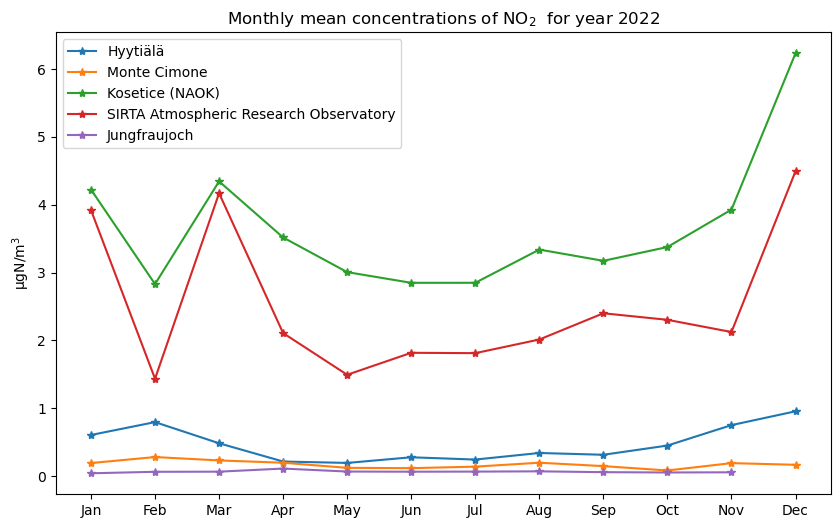

In [13]:
plt.figure(figsize=(10, 6))
for i in range(len(monthly_means_all_sites)):
    plt.plot(monthly_means_all_sites[i], label=site_name_list[i], marker='*')

plt.legend()
plt.ylabel('µgN/m$^3$')
plt.title('Monthly mean concentrations of NO$_2$  for year %d' % year_interested)
plt.xticks(np.arange(0, 12), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.show()

#### Make a table with the aggregated data

In [14]:
#Define a file to included in the table
data = []

Months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

for site_monthly, site_annual in zip(monthly_means_all_sites, annual_means_all_sites):
    site_name = site_monthly.attrs['ebas_station_name']
    lat = round(float(site_monthly.attrs['ebas_station_latitude']), 2)
    lon = round(float(site_monthly.attrs['ebas_station_longitude']),2)
    monthly_means = [round(mean, 2) for mean in site_monthly.values.tolist()] # Extract and round monthly means
    annual_mean = [round(mean, 2) for mean in site_annual.values.tolist()] # Extract and round annual mean
     # Append data to the list
    data.append([site_name, lat, lon] + monthly_means + annual_mean) 

# Define column names
columns = ['Site Name', 'Latitude', 'Longitude'] + Months + ['Annual Mean']

# Create DataFrame
df_no2_2022 = pd.DataFrame(data, columns=columns)
df_no2_2022

,Site Name,Latitude,Longitude,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,Annual Mean
0,Hyytiälä,61.85,24.28,0.60,0.79,0.48,0.21,0.19,0.28,0.24,0.34,0.31,0.45,0.75,0.95,0.47
1,Monte Cimone,44.19,10.70,0.19,0.28,0.23,0.20,0.12,0.12,0.14,0.20,0.15,0.08,0.19,0.16,0.17
2,Kosetice (NAOK),49.57,15.08,4.22,2.83,4.34,3.52,3.01,2.85,2.85,3.34,3.17,3.38,3.93,6.23,3.62
3,SIRTA Atmospheric Research Observatory,48.71,2.15,3.92,1.43,4.17,2.11,1.49,1.82,1.81,2.01,2.40,2.30,2.12,4.49,2.53
4,Jungfraujoch,46.55,7.99,0.04,0.06,0.06,0.11,0.07,0.06,0.06,0.07,0.06,0.05,0.05,NaN,0.06


### Make a map plot with the annual means colored by its average value

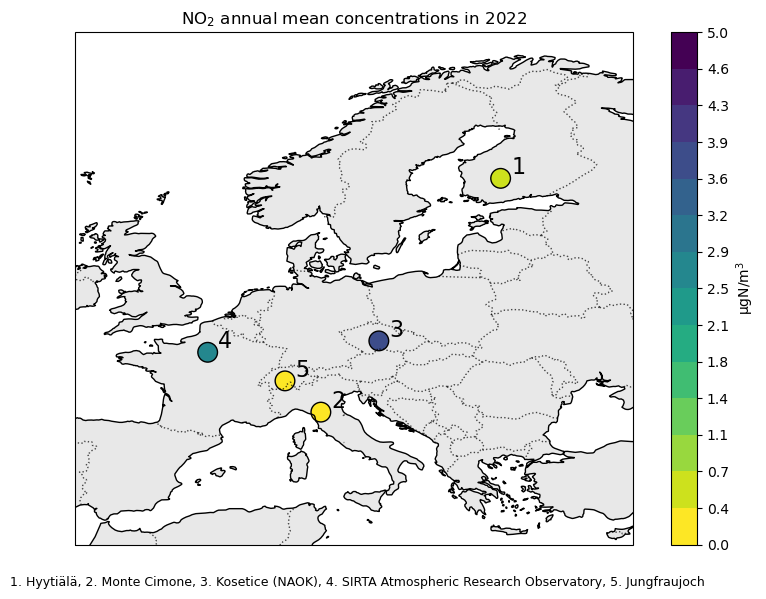

In [15]:
#Extract data from the df_no2_2022 DataFrame created above
site_name_list = df_no2_2022['Site Name'].tolist()
longitudes = df_no2_2022['Longitude'].tolist()
latitudes = df_no2_2022['Latitude'].tolist()
mean_values = df_no2_2022['Annual Mean'].tolist()

#Choose max and min - this will depend on your data
minval=0
maxval=5 

# Create the map plot
fig, ax = plt.subplots(figsize=(8, 6), subplot_kw={'projection': ccrs.PlateCarree()})

# Add map features (coastlines, borders, etc.)
ax.add_feature(cfeature.BORDERS, linestyle=':', alpha=0.7)
ax.add_feature(cfeature.COASTLINE, linewidth=1)

# Fill the continents with a light grey color
ax.add_feature(cfeature.LAND, facecolor='lightgrey', alpha=0.5)

# Define discrete color levels and the colormap
cmap = cm.get_cmap('viridis').reversed()  # Choose your colormap, e.g., 'viridis', 'plasma', etc.
ncolors = 15  # 15 color levels
levels = np.linspace(minval, maxval, ncolors)  # Discrete values for the colorbar (e.g., from 0 to 1)
norm = BoundaryNorm(boundaries=levels, ncolors=cmap.N)

# Plot the stations as colored circles
sc = ax.scatter(longitudes, latitudes, c=mean_values, cmap=cmap, norm=norm, s=200, edgecolor='black')

# Numerate the stations on the map
for i, (lon, lat) in enumerate(zip(longitudes, latitudes), start=1):
    ax.text(lon + 0.8, lat + 0.8, str(i), fontsize=16, ha='left', va='center', 
            transform=ccrs.PlateCarree())  # , fontweight='bold')

# Add a colorbar with discrete intervals
cbar = plt.colorbar(sc, ax=ax, orientation='vertical', pad=0.05)
cbar.set_label('µgN/m$^3$')
cbar.set_ticks(levels)  # Set colorbar ticks to discrete levels
cbar.ax.set_yticklabels([f'{level:.1f}' for level in levels])  # Customize tick labels if needed

# Set titles, labels, and other map properties
ax.set_title('NO$_2$ annual mean concentrations in ' + str(year_interested))

ax.set_extent([min(longitudes) - 10, max(longitudes) + 10, min(latitudes) - 10, max(latitudes) + 10])  # Set the extent of the map

# Add the legend as text, positioned just below the map
legend_text = ", ".join([f"{i}. {name}" for i, name in enumerate(site_name_list, start=1)])
plt.figtext(0.01, 0.02, legend_text, ha="left", fontsize=9, wrap=True)

# Adjust the layout to avoid cutting off the legend
plt.tight_layout(rect=[0, 0.05, 1, 1])
plt.show()

To further analyse NO2 data by looking at trends and climatology, have a look at notebook example "Trends and clomatology NO2.ipynb". 